# How to forecast sales with promotions in Python 

How to forecast sales

In [103]:
#Locate imported packages
import sys
sys.path

#import pandas and numpy
import pandas as pd
import numpy as np

# From matplotlib, import pyplot under the alias plt
from matplotlib import pyplot as plt

#Import library
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Reading an excel file using Python
import os

In [80]:
# Give the location of your file
file = ("datasets/Promotiondata.xlsx")
 
#Load spreadsheet
data = pd.ExcelFile(file)

## Load a sheet into a DataFrame by name
sales_data = data.parse('Sheet1')

#Check results
print(sales_data.head())

   Month Month of year        sales promotion?
0      1           jan  1056.474018        yes
1      2           feb   886.508163         no
2      3           mar  1248.466485        yes
3      4           apr   971.776087         no
4      5           may  1098.510175         no


In [81]:
#Rename columns
sales_data.rename(columns={'promotion?': 'promotion', 'Month of year':'month_of_year'}, inplace = True)

#Check results
print(sales_data.columns)

Index(['Month', 'month_of_year', 'sales', 'promotion'], dtype='object')


## Visualize data

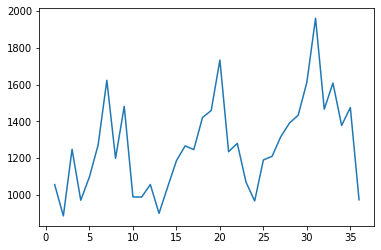

In [82]:
# Plot sales timeplot
plt.plot(sales_data.Month, sales_data.sales)

plt.show()

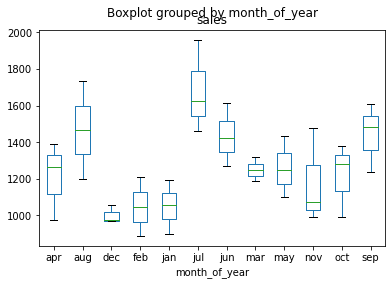

In [83]:
# Creating plot
bp = sales_data.boxplot(column = ['sales'], by ='month_of_year', grid=False)

plt.show()

In [93]:
#Average sales by month
sales_data.groupby('month_of_year')['sales'].mean().sort_values(ascending = False)

month_of_year
jul    1680.946535
aug    1466.298117
sep    1441.937378
jun    1435.165053
may    1259.559897
mar    1250.440606
oct    1216.073782
apr    1209.812088
nov    1178.303239
jan    1049.215876
feb    1047.059592
dec     999.615836
Name: sales, dtype: float64

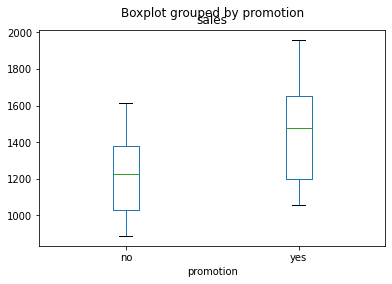

In [59]:
# Creating plot
bp = sales_data.boxplot(column = ['sales'], by ='promotion', grid=False)

plt.show()

In [87]:
#Average sales by promotion
sales_data.groupby('promotion')['sales'].mean().sort_values(ascending = False)

promotion
yes    1454.548259
no     1216.674926
Name: sales, dtype: float64

###### Insights from data visualization:


**1.** Sales appears to have been on a steady increase over the 3 years

**2.** Peak sales in July followed by August & September.

**3.** Average sales are higher when there is a promotion is higher than when there's no promotion (1455 vs 1217). Approx 238 more units.

## Prep data for forecast modeling

In [60]:
#from datetime import datetime
#Create date sequence of 36 months so we have a proper time object as our index
dates = pd.date_range('2011-01-01', periods=36, freq = 'MS')

print(dates)

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [61]:
#Add date sequence I just created to to dataframe
sales_data['dates'] = dates

#Check results
print(sales_data['dates'].head())

0   2011-01-01
1   2011-02-01
2   2011-03-01
3   2011-04-01
4   2011-05-01
Name: dates, dtype: datetime64[ns]


In [62]:
#Subset and rename columns needed for modeling
sales_data = sales_data[["dates", "sales", "promotion"]]

#Check results
print(sales_data.head())

       dates        sales promotion
0 2011-01-01  1056.474018       yes
1 2011-02-01   886.508163        no
2 2011-03-01  1248.466485       yes
3 2011-04-01   971.776087        no
4 2011-05-01  1098.510175        no


In [63]:
#Rename columns
sales_data.rename(columns = {'dates': 'ds', 'sales': 'y'},inplace = True)

#Check results of renaming
#print(sales_df.columns.values)
print(sales_data.columns)

Index(['ds', 'y', 'promotion'], dtype='object')


In [64]:
#Encode promotion variable (replace yes/no with either 1/0)
sales_data['promo'] = [1 if x == 'yes' else 0 for x in sales_data['promotion']]
      

print(sales_data.head())

          ds            y promotion  promo
0 2011-01-01  1056.474018       yes      1
1 2011-02-01   886.508163        no      0
2 2011-03-01  1248.466485       yes      1
3 2011-04-01   971.776087        no      0
4 2011-05-01  1098.510175        no      0


In [65]:
#Drop original promotion column
sales_data.drop(columns=['promotion'],axis=1,inplace=True)

print(sales_data.head())

          ds            y  promo
0 2011-01-01  1056.474018      1
1 2011-02-01   886.508163      0
2 2011-03-01  1248.466485      1
3 2011-04-01   971.776087      0
4 2011-05-01  1098.510175      0


# Test Train Split

In [68]:
#Test Train Split
import random

random.seed(10)

# train-test split
test_size = 12 # 12 months of data for test set
train_df = sales_data[:-test_size]
test_df = sales_data[-test_size:]


print(train_df.tail())

           ds            y  promo
19 2012-08-01  1733.428921      1
20 2012-09-01  1235.430716      0
21 2012-10-01  1280.645302      0
22 2012-11-01  1070.492064      0
23 2012-12-01   967.691859      0


# Run Prophet Model

In [88]:
#We need to initiate a Prophet object
m = Prophet(seasonality_mode='additive')
m.add_regressor('promo')

#Fit model
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.


Initial log joint probability = 8.54074
Iteration  1. Log joint probability =      18.81. Improved by 10.2693.
Iteration  2. Log joint probability =    33.2312. Improved by 14.4212.
Iteration  3. Log joint probability =    38.0952. Improved by 4.86401.
Iteration  4. Log joint probability =    41.4972. Improved by 3.402.
Iteration  5. Log joint probability =     41.788. Improved by 0.290822.
Iteration  6. Log joint probability =    41.8289. Improved by 0.0409205.
Iteration  7. Log joint probability =    41.8691. Improved by 0.0402188.
Iteration  8. Log joint probability =    41.9275. Improved by 0.05839.
Iteration  9. Log joint probability =    41.9662. Improved by 0.0387054.
Iteration 10. Log joint probability =     42.045. Improved by 0.078744.
Iteration 11. Log joint probability =    42.3306. Improved by 0.285615.
Iteration 12. Log joint probability =    42.3624. Improved by 0.0318395.
Iteration 13. Log joint probability =    42.5299. Improved by 0.16749.
Iteration 14. Log joint prob

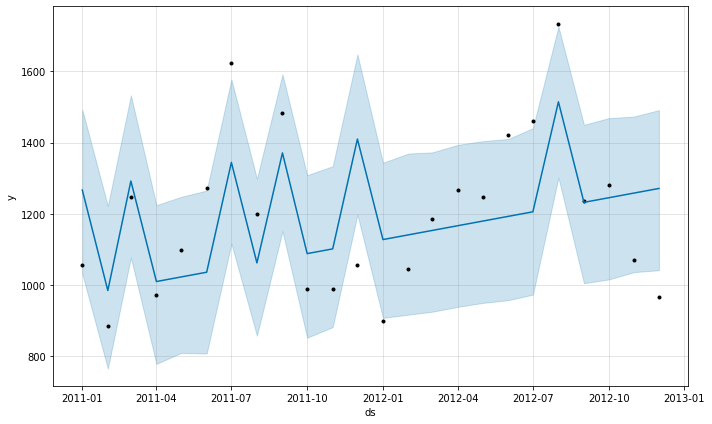

In [89]:
#Create forecast using predict function - if no future dataframe is created then the predict function will simply predict values on the historical data that was fit in the model
#We just want to see how Prophet handeled seasonality
forecast = m.predict()

#Plot the historical forecast
fig_a_model = m.plot(forecast)
plt.show()

### Make predictions on the test set 

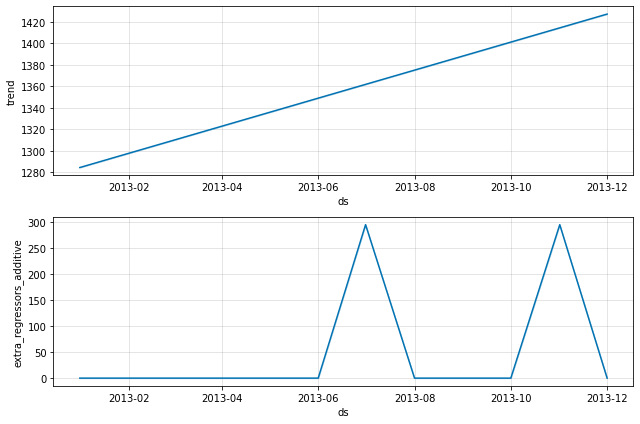

In [90]:
#Create forecast using predict function on the test data set
forecast = m.predict(test_df)
fig = m.plot_components(forecast)

#Prints forecast to console
#print(forecast)

In [91]:
#Coefficients of regressors 
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,promo,additive,0.0,295.247008,295.247008,295.247008


The default is no promotion so when there is no promotion the average sales is the base level. When there is a promotion then we can expect to sell nearly 300 extra units.

## Evaluation Model

In [107]:
df_cv = cross_validation(m,
                         horizon='90 days',
                        parallel='processes')

INFO:prophet:Making 8 forecasts with cutoffs between 2011-10-23 00:00:00 and 2012-09-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbeac058250>
INFO:prophet:n_changepoints greater than number of observations. Using 8.



Initial log joint probability = -3.24289
Iteration  1. Log joint probability =    9.90289. Improved by 13.1458.
Iteration  2. Log joint probability =    17.0613. Improved by 7.15845.
Iteration  3. Log joint probability =    19.8871. Improved by 2.82575.
Iteration  4. Log joint probability =    20.0625. Improved by 0.175431.
Iteration  5. Log joint probability =    20.0708. Improved by 0.00825127.
Iteration  6. Log joint probability =     20.109. Improved by 0.0382319.
Iteration  7. Log joint probability =    20.4066. Improved by 0.297563.
Iteration  8. Log joint probability =    20.4186. Improved by 0.0120345.

Initial log joint probability = -3.73349
Iteration  9. Log joint probability =    20.4899. Improved by 0.0712801.
Iteration 10. Log joint probability =    20.5142. Improved by 0.0243438.
Iteration 11. Log joint probability =     20.592. Improved by 0.0777624.
Iteration 12. Log joint probability =    20.6519. Improved by 0.0598926.
Iteration 13. Log joint probability =    20.751

INFO:prophet:n_changepoints greater than number of observations. Using 7.


Iteration 14. Log joint probability =    20.7598. Improved by 0.00793093.


INFO:prophet:n_changepoints greater than number of observations. Using 9.


Iteration  1. Log joint probability =    7.26473. Improved by 10.9982.
Iteration 15. Log joint probability =    20.7721. Improved by 0.0123662.
Iteration 16. Log joint probability =     20.783. Improved by 0.010833.
Iteration 17. Log joint probability =    20.7893. Improved by 0.00635627.
Iteration 18. Log joint probability =     20.794. Improved by 0.00462964.

Initial log joint probability = -1.91354
Iteration 19. Log joint probability =    20.7951. Improved by 0.00110211.
Iteration 20. Log joint probability =    20.7975. Improved by 0.00243563.
Iteration 21. Log joint probability =    20.7986. Improved by 0.00106712.
Iteration 22. Log joint probability =    20.7991. Improved by 0.000488555.
Iteration 23. Log joint probability =    20.7995. Improved by 0.000417341.
Iteration 24. Log joint probability =    20.8001. Improved by 0.000600878.
Iteration 25. Log joint probability =    20.8004. Improved by 0.000334093.
Iteration 26. Log joint probability =    20.8005. Improved by 4.91027e-0

INFO:prophet:n_changepoints greater than number of observations. Using 11.


Iteration 52. Log joint probability =    20.3785. Improved by 2.21807e-07.
Iteration 53. Log joint probability =    20.3785. Improved by 3.14629e-07.
Iteration 54. Log joint probability =    20.3785. Improved by 1.57729e-07.
Iteration 55. Log joint probability =    20.3785. Improved by 9.52108e-08.
Iteration 56. Log joint probability =    20.3785. Improved by 2.33317e-07.
Iteration 57. Log joint probability =    20.3785. Improved by 8.58581e-08.
Iteration 58. Log joint probability =    20.3785. Improved by 4.5838e-09.
Iteration 10. Log joint probability =    26.6194. Improved by 0.0111802.
Iteration 11. Log joint probability =    26.6427. Improved by 0.0233274.
Iteration 12. Log joint probability =    26.6586. Improved by 0.0158527.
Iteration 13. Log joint probability =     26.747. Improved by 0.0883907.
Iteration 14. Log joint probability =    26.7561. Improved by 0.00913673.
Iteration 15. Log joint probability =    26.7721. Improved by 0.0159547.
Iteration 16. Log joint probability =

INFO:prophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -0.0171934
Iteration  1. Log joint probability =    16.0219. Improved by 16.0391.
Iteration  2. Log joint probability =    21.9644. Improved by 5.94247.

Initial log joint probability = 2.71324
Iteration  3. Log joint probability =    27.4538. Improved by 5.48941.
Iteration  4. Log joint probability =    28.0429. Improved by 0.58908.
Iteration  1. Log joint probability =    17.7661. Improved by 15.0529.
Iteration  5. Log joint probability =    28.2968. Improved by 0.25394.


INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 14.



Initial log joint probability = 4.08982
Iteration  2. Log joint probability =    28.5514. Improved by 10.7853.
Iteration  6. Log joint probability =     28.302. Improved by 0.00518685.
Iteration  1. Log joint probability =    18.9162. Improved by 14.8264.
Iteration  3. Log joint probability =    31.9739. Improved by 3.42254.
Iteration  7. Log joint probability =    28.3116. Improved by 0.0096415.
Iteration  8. Log joint probability =    28.3281. Improved by 0.0164547.
Iteration  4. Log joint probability =    32.0177. Improved by 0.0437509.
Iteration  5. Log joint probability =    32.0443. Improved by 0.0266541.
Iteration  6. Log joint probability =    32.0809. Improved by 0.0366134.
Iteration  9. Log joint probability =    28.4032. Improved by 0.0750992.
Iteration  2. Log joint probability =    29.7527. Improved by 10.8365.
Iteration  7. Log joint probability =     32.093. Improved by 0.0120416.
Iteration  8. Log joint probability =    32.1002. Improved by 0.0072627.
Iteration  9. Log

INFO:prophet:n_changepoints greater than number of observations. Using 15.


Iteration 46. Log joint probability =    28.6382. Improved by 1.13682e-06.
Iteration 30. Log joint probability =    33.7219. Improved by 3.25805e-06.
Iteration 47. Log joint probability =    28.6382. Improved by 2.08641e-07.
Iteration 48. Log joint probability =    28.6382. Improved by 3.90409e-07.
Iteration 31. Log joint probability =     33.722. Improved by 2.02621e-06.
Iteration 32. Log joint probability =     33.722. Improved by 1.4714e-06.
Iteration 49. Log joint probability =    28.6382. Improved by 3.232e-07.
Iteration 33. Log joint probability =     33.722. Improved by 2.22297e-06.
Iteration 50. Log joint probability =    28.6382. Improved by 5.43454e-07.
Iteration 34. Log joint probability =     33.722. Improved by 1.29396e-06.
Iteration 51. Log joint probability =    28.6382. Improved by 8.63971e-08.
Iteration 35. Log joint probability =     33.722. Improved by 1.13211e-06.
Iteration  1. Log joint probability =    20.8324. Improved by 16.2712.
Iteration 52. Log joint probabil

In [102]:
#Print cross-validated df
print(df_cv)

           ds         yhat   yhat_lower   yhat_upper            y     cutoff
0  2011-11-01  1280.671999  1113.231723  1438.361616   989.069718 2011-10-23
1  2011-12-01  1637.640052  1474.657289  1788.194507  1056.967932 2011-10-23
2  2012-01-01  1362.187530  1198.006810  1534.962973   900.564854 2011-10-23
3  2012-01-01  1112.790162   914.135462  1344.175304   900.564854 2011-12-07
4  2012-02-01  1121.499038   880.077115  1329.859251  1044.444705 2011-12-07
5  2012-03-01  1129.646052   902.853434  1357.330550  1185.929539 2011-12-07
6  2012-02-01  1051.969130   849.961780  1286.000782  1044.444705 2012-01-21
7  2012-03-01  1053.910076   840.990021  1279.988654  1185.929539 2012-01-21
8  2012-04-01  1055.984880   827.414235  1264.639362  1266.781988 2012-01-21
9  2012-04-01  1088.849982   880.726137  1308.658839  1266.781988 2012-03-06
10 2012-05-01  1093.732665   884.996267  1302.957743  1246.991980 2012-03-06
11 2012-06-01  1098.778105   900.839163  1315.339065  1420.927686 2012-03-06

In [104]:
#Pring performance metrics - check accuracy
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,11 days,5854.118718,76.512213,57.733548,0.046883,0.046883,0.048828,1.0
1,13 days,20146.007346,141.936631,121.654025,0.076970,0.096809,0.080970,1.0
2,25 days,39738.738583,199.345776,198.899905,0.171357,0.171357,0.161964,0.5
3,26 days,38349.689951,195.830769,195.078657,0.188059,0.188059,0.180944,0.5
4,27 days,39996.165713,199.990414,198.889309,0.145571,0.145571,0.157015,0.5


/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


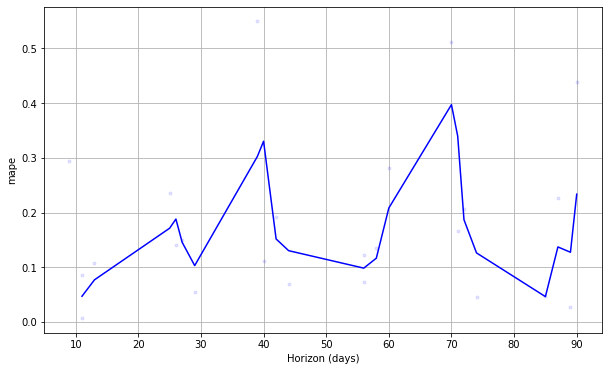

In [105]:

fig = plot_cross_validation_metric(df_cv, metric='mape')